In [1]:
import numpy as np
import pandas as pd
from folium import plugins
import datetime
import folium
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.stattools import durbin_watson
warnings.filterwarnings("ignore")
from pmdarima.arima import auto_arima

In [2]:
raw_weather_data = pd.read_csv('weather_processed.csv')

In [3]:
np.unique(raw_weather_data[['StationName']])

array(['BERGEN POINT', 'CENTRAL PARK',
       'JOHN F KENNEDY INTERNATIONAL AIRPORT', 'KINGS POINT',
       'LA GUARDIA AIRPORT', 'PORT AUTH DOWNTN MANHATTAN WALL ST HEL',
       'THE BATTERY'], dtype=object)

In [4]:
raw_call_data = pd.read_csv('311_calls_data.csv')
raw_call_data.head(10)

,Unique Key,Agency,Complaint Type,Descriptor,Borough,Latitude,Longitude,Day
0,38237851,DSNY,Request Large Bulky Item Collection,Request Large Bulky Item Collection,BROOKLYN,40.730013,-73.956267,2018-01-17
1,38237852,DSNY,Request Large Bulky Item Collection,Request Large Bulky Item Collection,STATEN ISLAND,40.558494,-74.141962,2018-01-17
2,38237855,DSNY,Request Large Bulky Item Collection,Request Large Bulky Item Collection,QUEENS,40.754075,-73.775594,2018-01-17
3,38237856,DSNY,Request Large Bulky Item Collection,Request Large Bulky Item Collection,BRONX,40.884181,-73.859111,2018-01-17
4,38237857,DSNY,Request Large Bulky Item Collection,Request Large Bulky Item Collection,BROOKLYN,40.672113,-73.977242,2018-01-17
5,38237858,DSNY,Request Large Bulky Item Collection,Request Large Bulky Item Collection,BROOKLYN,40.688114,-74.000184,2018-01-17
6,38237859,DSNY,Request Large Bulky Item Collection,Request Large Bulky Item Collection,BROOKLYN,40.674727,-73.941122,2018-01-17
7,38237860,DSNY,Request Large Bulky Item Collection,Request Large Bulky Item Collection,BRONX,40.882667,-73.847632,2018-01-17
8,38237861,DSNY,Request Large Bulky Item Collection,Request Large Bulky Item Collection,MANHATTAN,40.823467,-73.953275,2018-01-17
9,38237862,DSNY,Request Large Bulky Item Collection,Request Large Bulky Item Collection,BROOKLYN,40.676137,-73.979779,2018-01-17


In [5]:
raw_call_data['Day'] = pd.to_datetime(raw_call_data['Day'])

In [6]:
raw_call_data_whole = raw_call_data.copy()
raw_call_data_whole['count'] = 1
whole_df = raw_call_data_whole[['Day','count']].groupby('Day',as_index = False).count().sort_values('Day')

In [7]:
# get call numbers group by boroughs and days
raw_call_data_by_borough = raw_call_data.copy()
raw_call_data_by_borough['count'] = 1
by_borough_df = raw_call_data_by_borough[['Day','Borough','count']].groupby(['Day','Borough'],as_index = False).count().sort_values(['Day','Borough'])
by_borough_df.head(10)

,Day,Borough,count
0,2016-01-01,BRONX,976
1,2016-01-01,BROOKLYN,1298
2,2016-01-01,MANHATTAN,972
3,2016-01-01,QUEENS,900
4,2016-01-01,STATEN ISLAND,125
5,2016-01-02,BRONX,1028
6,2016-01-02,BROOKLYN,1380
7,2016-01-02,MANHATTAN,1055
8,2016-01-02,QUEENS,881
9,2016-01-02,STATEN ISLAND,166


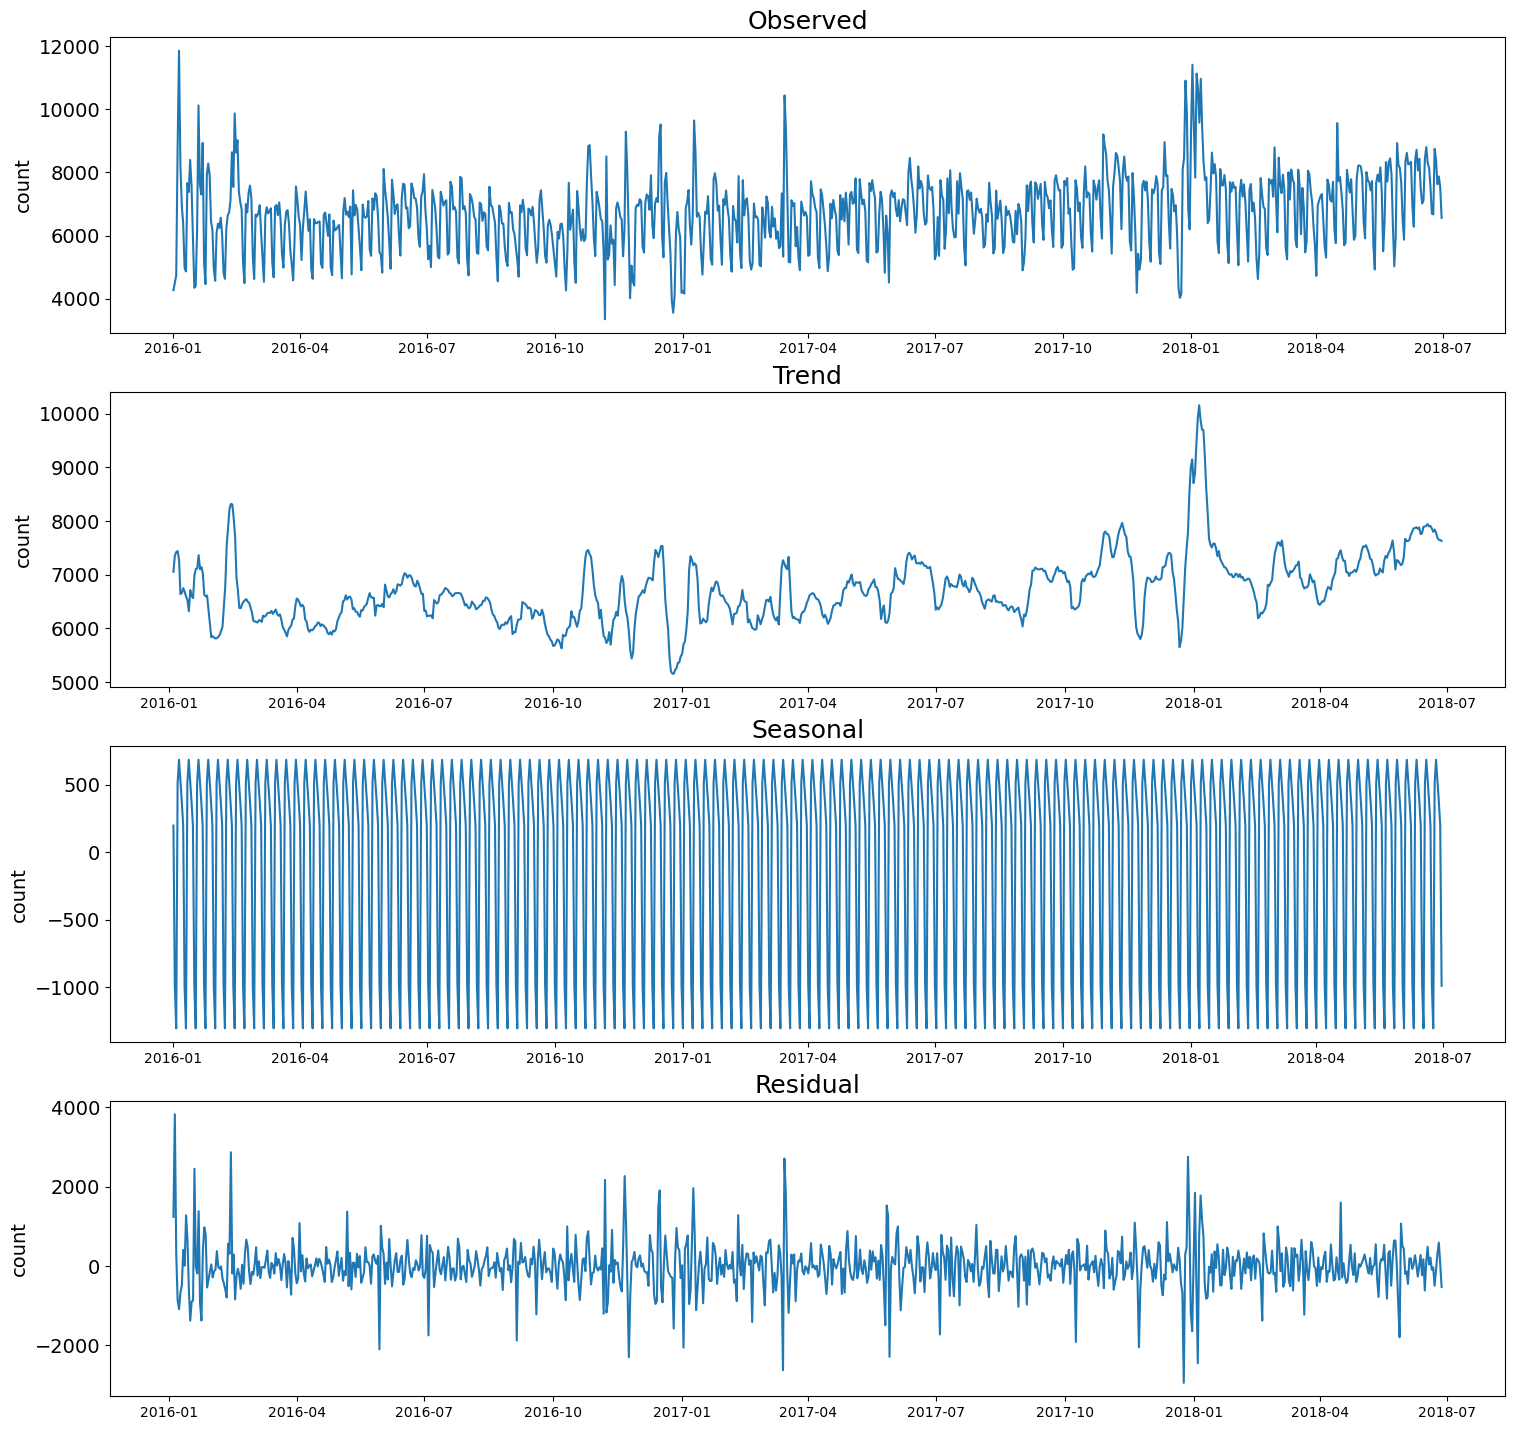

In [8]:
# seasonal decomposite plots
whole_series = whole_df['count']
whole_series.index = whole_df['Day']
whole_series_train = whole_series[whole_series.index < datetime.datetime(2018,7,1)]
whole_series_test = whole_series[whole_series.index >= datetime.datetime(2018,7,1)]
train_decomposite = seasonal_decompose(whole_series_train,model='addictive')
fig,ax = plt.subplots(4,1,figsize=(18,18), dpi = 100)
ax.flatten()
sns.lineplot(train_decomposite.observed.index, train_decomposite.observed, ax = ax[0])
sns.lineplot(train_decomposite.observed.index, train_decomposite.trend, ax = ax[1])
sns.lineplot(train_decomposite.observed.index, train_decomposite.seasonal, ax = ax[2])
sns.lineplot(train_decomposite.observed.index, train_decomposite.resid, ax = ax[3])
ax[0].set_title('Observed', fontsize = 18)
ax[0].set_xlabel(None)
ax[0].set_ylabel('count', fontsize = 14)
ax[1].set_title('Trend', fontsize = 18)
ax[1].set_xlabel(None)
ax[1].set_ylabel('count', fontsize = 14)
ax[2].set_title('Seasonal', fontsize = 18)
ax[2].set_xlabel(None)
ax[2].set_ylabel('count', fontsize = 14)
ax[3].set_title('Residual', fontsize = 18)
ax[3].set_xlabel(None)
ax[3].set_ylabel('count', fontsize = 14)
ax[0].tick_params(axis="y", labelsize=14)
ax[1].tick_params(axis="y", labelsize=14)
ax[2].tick_params(axis="y", labelsize=14)
ax[3].tick_params(axis="y", labelsize=14)


<AxesSubplot:xlabel='Day', ylabel='resid'>

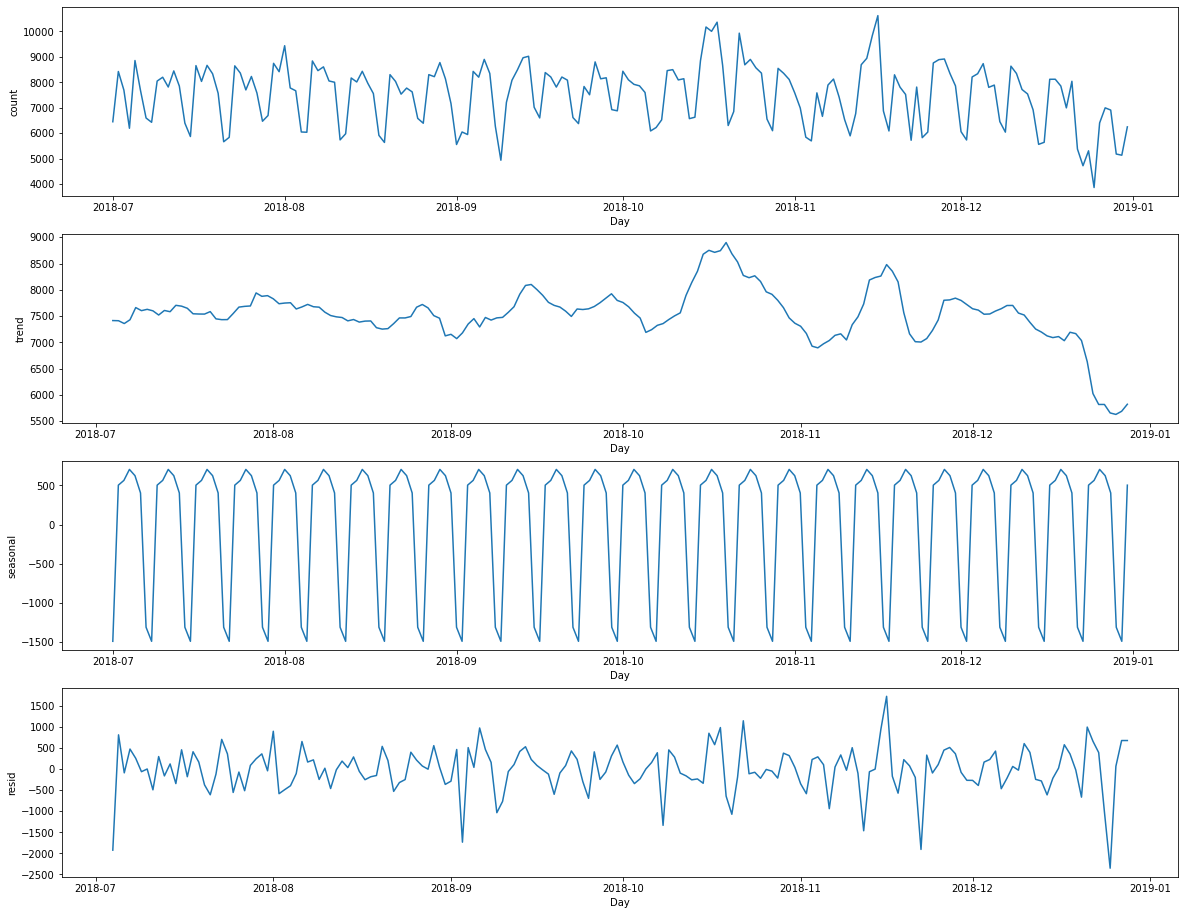

In [9]:
# test set seasonal decomposite
test_decomposite = seasonal_decompose(whole_series_test,model='addictive')
fig,ax = plt.subplots(4,1,figsize=(20,16))
ax.flatten()
sns.lineplot(test_decomposite.observed.index, test_decomposite.observed, ax = ax[0])
sns.lineplot(test_decomposite.observed.index, test_decomposite.trend, ax = ax[1])
sns.lineplot(test_decomposite.observed.index, test_decomposite.seasonal, ax = ax[2])
sns.lineplot(test_decomposite.observed.index, test_decomposite.resid, ax = ax[3])

# Stationary Test

In [10]:
#stationary test of decomosed residuals
from statsmodels.tsa.stattools import adfuller
adft = adfuller(train_decomposite.resid.fillna(0))
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

         Values                       Metric
0 -1.274163e+01              Test Statistics
1  8.918915e-24                      p-value
2  2.100000e+01             No. of lags used
3  8.900000e+02  Number of observations used
4 -3.437719e+00          critical value (1%)
5 -2.864793e+00          critical value (5%)
6 -2.568502e+00         critical value (10%)


## Prediction with observed data

In [11]:
# Baseline model
model = auto_arima(whole_series_train, trace=True, error_action='ignore',\
                   suppress_warnings=True, information_criterion = 'aic')

forecast = model.predict(n_periods=len(whole_series_test))
forecast = pd.DataFrame(forecast,index = whole_series_test.index,columns=['Prediction'])

seven_day_forecast = model.predict(n_periods=len(whole_series_test) + 7)
seven_day_ind = list(whole_series_test.index)
seven_day_ind.extend([datetime.datetime(2019,1,i) for i in range(1,8)])

seven_day_forecast = pd.DataFrame(seven_day_forecast,index = seven_day_ind,columns=['Prediction'])
seven_day_pred_base = np.array(seven_day_forecast['Prediction'][-7:])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15457.268, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15449.099, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15378.704, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15455.273, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15376.949, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=15185.449, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=15447.105, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=15135.426, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=15356.858, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=15137.421, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1

[None, None]

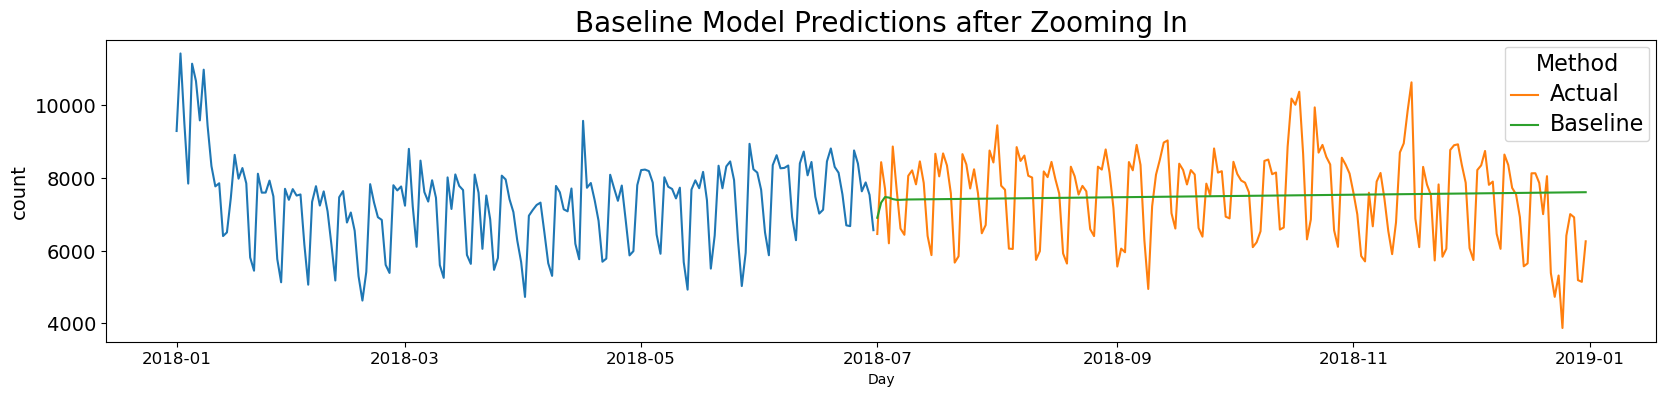

In [12]:
whole_series_train_2018 = whole_series_train[whole_series_train.index >=datetime.datetime(2018,1,1)]
fig,ax = plt.subplots(1,1,figsize=(20,4),dpi= 100)
sns.lineplot(whole_series_train_2018.index, whole_series_train_2018, ax = ax)
sns.lineplot(whole_series_test.index, whole_series_test, ax = ax,label = 'Actual')
sns.lineplot(whole_series_test.index, forecast['Prediction'], ax = ax,label='Baseline')
ax.set_title('Baseline Model Predictions after Zooming In', fontsize= 20)
ax.set_ylabel('count', fontsize = 14)
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.legend()
ax.legend(title = 'Method',ncol=1,loc=1)
plt.setp(ax.get_legend().get_texts(), fontsize="16")  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize="16")


## Prediction with only residual

In [13]:
train_residual = train_decomposite.resid.fillna(0)
train_rest = train_decomposite.observed - train_decomposite.resid.fillna(0)
train_total = train_residual + train_rest
test_residual = test_decomposite.resid.fillna(0)
test_rest = test_decomposite.observed - test_decomposite.resid.fillna(0)
test_total = test_residual + test_rest


In [14]:
from pmdarima.arima import auto_arima

residual_model = auto_arima(train_residual, trace=True, error_action='ignore', suppress_warnings=True, information_criterion = 'aic')

residual_forecast = residual_model.predict(n_periods=len(test_residual))
residual_forecast = pd.DataFrame(residual_forecast,index = test_residual.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=14202.413, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=14202.480, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=14200.246, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14200.445, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=14198.272, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=14200.509, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.925 seconds


In [15]:
seven_day_forecast_res = residual_model.predict(n_periods=len(test_residual)+7)
seven_day_ind_res = list(test_residual.index)
seven_day_ind_res.extend([datetime.datetime(2019,1,i) for i in range(1,8)])

seven_day_forecast_res = pd.DataFrame(seven_day_forecast_res,index = seven_day_ind_res, columns=['Prediction'])
seven_day_pred_res = np.array(seven_day_forecast_res['Prediction'][-7:]) + np.array(test_rest[-7:])

[None, None]

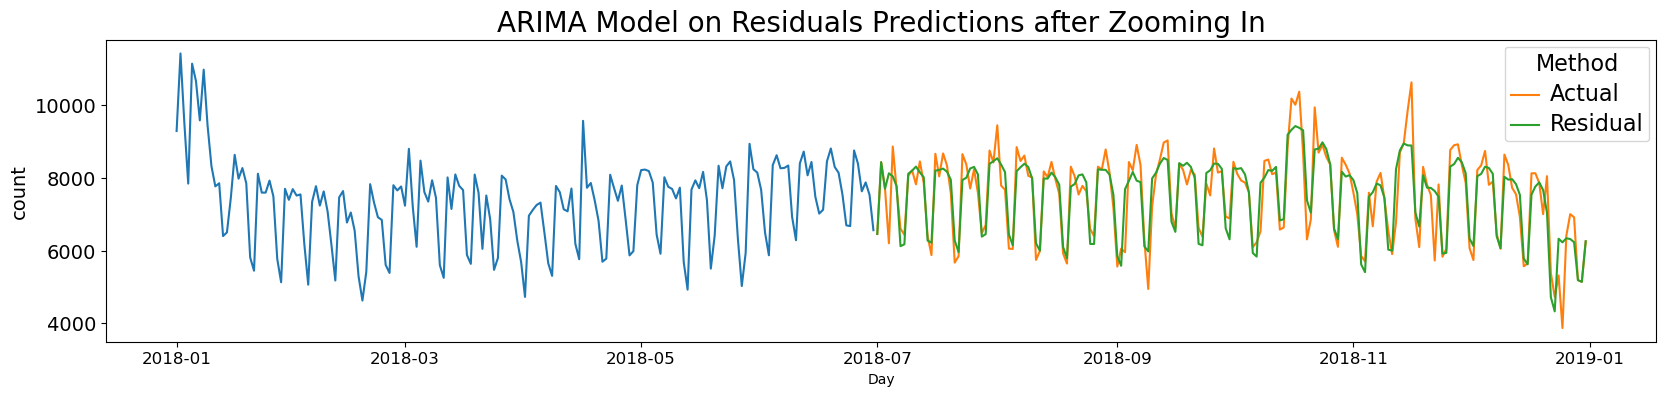

In [16]:
train_total_2018 = train_total[train_total.index >=datetime.datetime(2018,1,1)]

fig,ax = plt.subplots(1,1,figsize=(20,4),dpi= 100)
sns.lineplot(train_total_2018.index, train_total_2018, ax = ax)
sns.lineplot(test_total.index, test_total, ax = ax,label = 'Actual')
sns.lineplot(test_total.index, residual_forecast['Prediction'] + test_rest, ax = ax,label = 'Residual')
ax.set_title('ARIMA Model on Residuals Predictions after Zooming In', fontsize= 20)
ax.set_ylabel('count', fontsize = 14)
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.legend(title = 'Method',ncol=1,loc=1)
plt.setp(ax.get_legend().get_texts(), fontsize="16")  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize="16")

## Borough Prediction

In [17]:
total_forcast = []
seven_day_pred_bor_list = []
Borough_names = ["BRONX","BROOKLYN","STATEN ISLAND","QUEENS", "MANHATTAN"]
for name in Borough_names:  
    # borough data split
    borough_series = by_borough_df[by_borough_df.Borough == name]['count']
    borough_series.index = by_borough_df[by_borough_df.Borough == name]['Day']
    
    # train test split and decomposite
    borough_series_train = borough_series[borough_series.index < datetime.datetime(2018,7,1)]
    borough_series_test = borough_series[borough_series.index >= datetime.datetime(2018,7,1)]
    borough_train_decomposite = seasonal_decompose(borough_series_train,model='addictive')
    borough_test_decomposite = seasonal_decompose(borough_series_test,model='addictive')
    
    # preprocessing
    borough_train_residual = borough_train_decomposite.resid.fillna(0)
    borough_train_rest = borough_train_decomposite.observed - borough_train_decomposite.resid.fillna(0)
    borough_train_total = borough_train_residual + borough_train_rest
    borough_test_residual = borough_test_decomposite.resid.fillna(0)
    borough_test_rest = borough_test_decomposite.observed - borough_test_decomposite.resid.fillna(0)
    borough_test_total = borough_test_residual + test_rest
    
    
    # borough model build and forcast
    borough_hmodel = auto_arima(borough_train_residual, trace=True, error_action='ignore', suppress_warnings=True,\
                              information_criterion = 'aic')
    
    borough_forecast = borough_hmodel.predict(n_periods=len(borough_test_residual))
    borough_forecast = pd.DataFrame(borough_forecast,index = borough_test_residual.index,columns=['Prediction'])
    total_forcast.append(borough_forecast['Prediction'] + borough_test_rest)
    
    seven_day_forecast_bor = residual_model.predict(n_periods=len(borough_test_residual)+7)
    seven_day_ind_bor = list(borough_test_residual.index)
    seven_day_ind_bor.extend([datetime.datetime(2019,1,i) for i in range(1,8)])

    seven_day_forecast_bor = pd.DataFrame(seven_day_forecast_bor,index = seven_day_ind_bor, columns=['Prediction'])
    seven_day_pred_bor_tmp = np.array(seven_day_forecast_bor['Prediction'][-7:]) + np.array(borough_test_rest[-7:])
    seven_day_pred_bor_list.append(seven_day_pred_bor_tmp)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=11734.354, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=11726.222, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=11718.197, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11732.386, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11716.220, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11724.248, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.892 seconds
Performing stepwise search to minimize aic
 ARIMA(2

In [18]:
seven_day_forecast_res = residual_model.predict(n_periods=len(test_residual)+7)
seven_day_ind_res = list(test_residual.index)
seven_day_ind_res.extend([datetime.datetime(2019,1,i) for i in range(1,8)])

seven_day_forecast_res = pd.DataFrame(seven_day_forecast_res,index = seven_day_ind_res, columns=['Prediction'])
seven_day_pred_res = np.array(seven_day_forecast_res['Prediction'][-7:]) + np.array(test_rest[-7:])

[None, None]

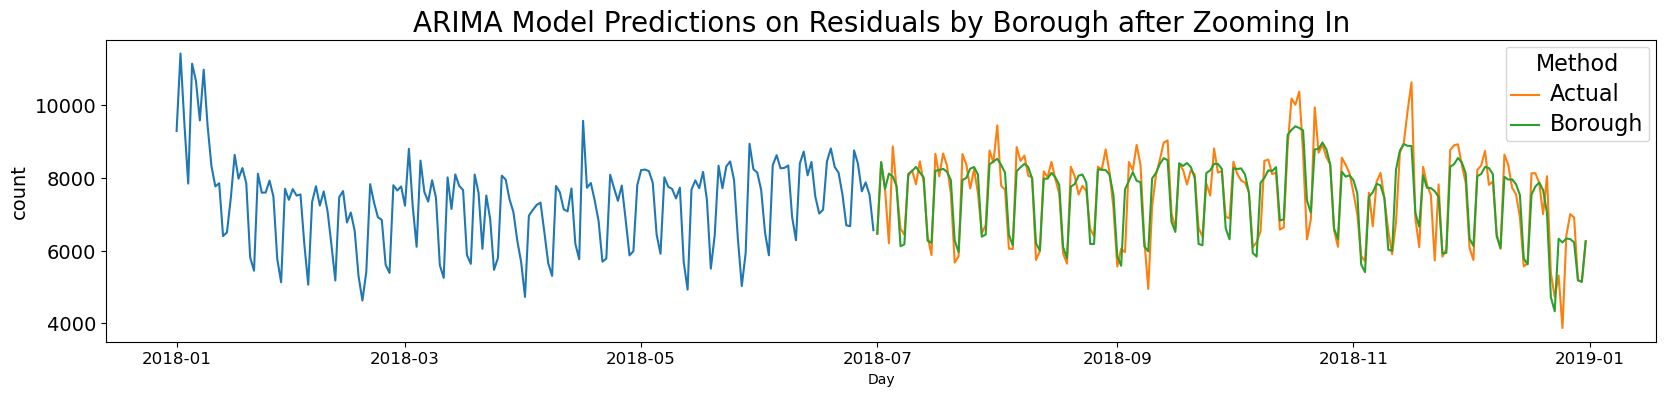

In [19]:
train_total_2018 = train_total[train_total.index >=datetime.datetime(2018,1,1)]

fig,ax = plt.subplots(1,1,figsize=(20,4),dpi =100)
sns.lineplot(train_total_2018.index, train_total_2018, ax = ax)
sns.lineplot(test_total.index, test_total, ax = ax,label = 'Actual')
sns.lineplot(test_total.index, np.sum(total_forcast, axis = 0), ax = ax,label = 'Borough')
ax.set_title('ARIMA Model Predictions on Residuals by Borough after Zooming In', fontsize= 20)
ax.set_ylabel('count', fontsize = 14)
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.legend(title = 'Method',ncol=1,loc=1)
plt.setp(ax.get_legend().get_texts(), fontsize="16")  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize="16")

In [20]:
seven_day_pred_bor = np.sum(seven_day_pred_bor_list, axis = 0)

## Plot the Predictions of Three Methods Above

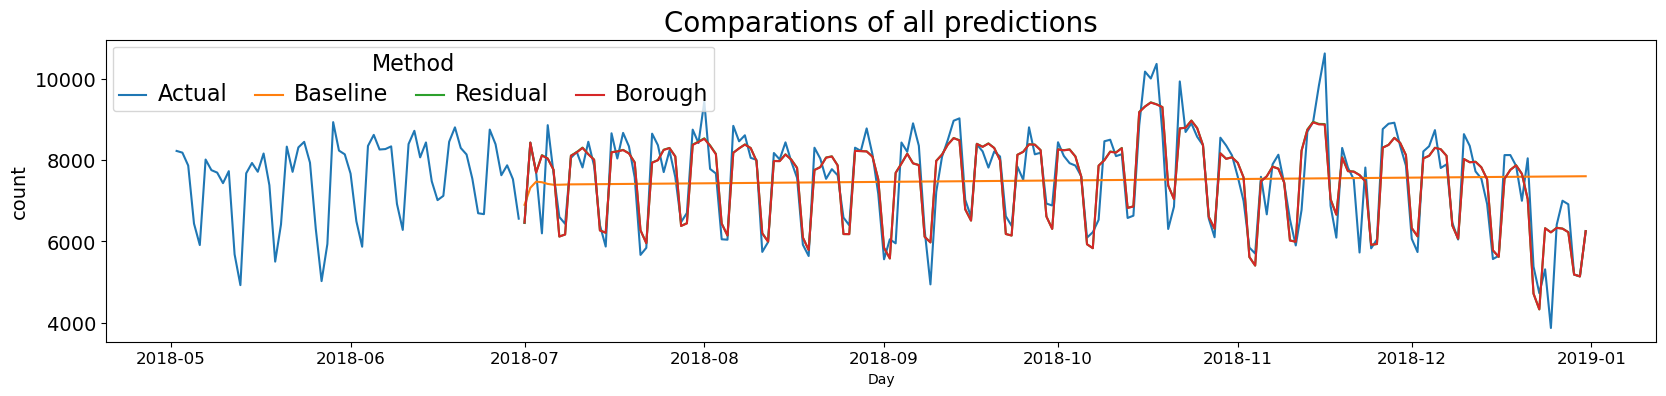

In [21]:
## Total plot
fig,ax = plt.subplots(1,1,figsize=(20,4),dpi=100)

sub_index = train_total_2018[train_total_2018.index > datetime.datetime(2018,5,1)]
sns.lineplot(sub_index.index, sub_index, ax = ax)

dates = test_total.index
data_preproc = pd.DataFrame({
    'Day': dates, 
    'Actual':  test_total,
    'Baseline': forecast['Prediction'],
    'Residual': residual_forecast['Prediction'] + test_rest,
    'Borough': np.sum(total_forcast, axis = 0)})


sns.lineplot(x='Day', y='counts', hue='Method', 
             data=pd.melt(data_preproc, ['Day']).rename(columns={'variable': 'Method', 'value': 'counts'}), ax = ax )

ax.set_title('Comparations of all predictions', fontsize= 20)
ax.set_ylabel('count', fontsize = 14)
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.legend(title = 'Method',ncol=5,loc=2)
plt.setp(ax.get_legend().get_texts(), fontsize="16")  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize="16")


"""
sns.lineplot(whole_series_test.index, forecast['Prediction'], ax = ax)
sns.lineplot(test_total.index, residual_forecast['Prediction'] + test_rest, ax = ax)
sns.lineplot(test_total.index, np.sum(total_forcast, axis = 0), ax = ax)
""";

## 7 Day Prediction for Above Three Methods

[None, None]

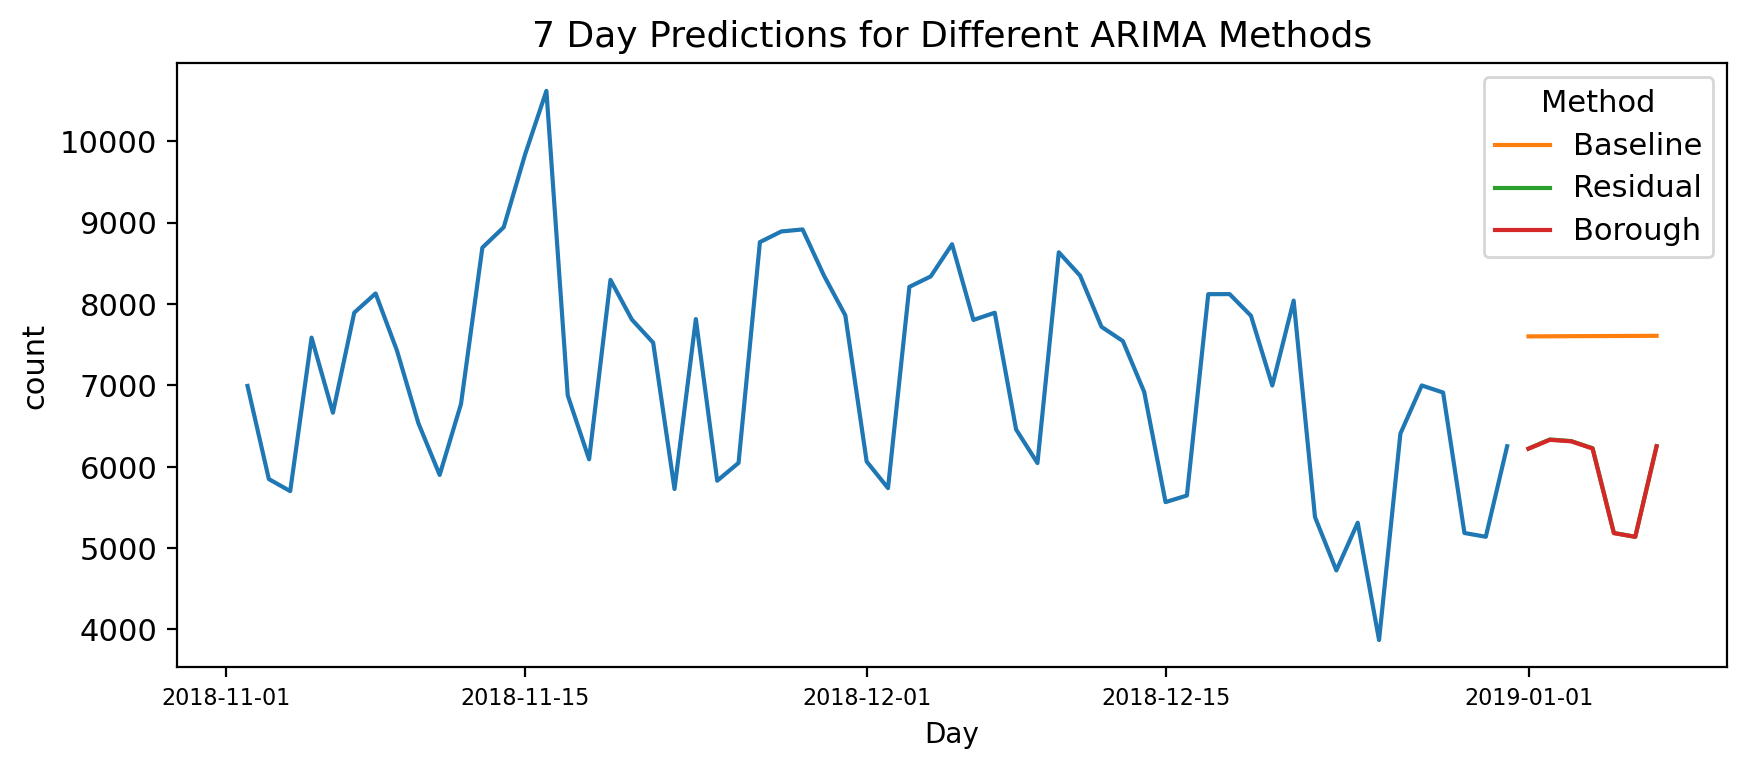

In [22]:
fig,ax = plt.subplots(1,1,figsize=(10,4),dpi =200)

sub_index = test_total[test_total.index > datetime.datetime(2018,11,1)]
sns.lineplot(sub_index.index, sub_index, ax = ax)

data_preproc_seven_day = pd.DataFrame({
    'Day': [datetime.datetime(2019,1,i) for i in range(1,8)],
    'Baseline': seven_day_pred_base,
    'Residual': seven_day_pred_res,
    'Borough': seven_day_pred_bor})
sns.lineplot(x='Day', y='counts', hue='Method', palette = sns.color_palette()[1:4],
            data=pd.melt(data_preproc_seven_day, ['Day']).rename(columns={'variable': 'Method', 'value': 'counts'}), ax = ax )

ax.set_title('7 Day Predictions for Different ARIMA Methods', fontsize= 13)
ax.set_ylabel('count', fontsize = 11)
ax.tick_params(axis="y", labelsize=11)
ax.tick_params(axis="x", labelsize=8)## Plot the Predictions of Three Methods Above
# ax.legend(title = 'Method',ncol=5,loc=1)
plt.setp(ax.get_legend().get_texts(), fontsize="11")  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize="11")

## Metrics

In [23]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape 
metrics_df =  pd.DataFrame({
    'Baseline': [mse(test_total, forecast['Prediction']),\
                 mse(test_total, forecast['Prediction'], squared=False),\
                mape(test_total, forecast['Prediction'])], 
    
    'Residual':  [mse(test_total, residual_forecast['Prediction'] + test_rest), \
                  mse(test_total, residual_forecast['Prediction'] + test_rest, squared=False),\
                 mape(test_total, residual_forecast['Prediction'] + test_rest)],
    
    'Borough': [mse(np.array(test_total), np.sum(total_forcast, axis = 0)),\
                mse(np.array(test_total),np.sum(total_forcast, axis = 0), squared=False),\
               mape(np.array(test_total), np.sum(total_forcast, axis = 0))]},
   index = ["MSE", "RMSE", "MAPE"])
metrics_df

,Baseline,Residual,Borough
MSE,1.461135e+06,289184.693119,289223.051681
RMSE,1.208774e+03,537.758954,537.794618
MAPE,1.455922e-01,0.052847,0.052830


# Linear Regression Model

In [24]:
# In this part we incroporate weather features to train a linear regression model

## Data Preparation

In [25]:
raw_weather_data.head(10)

,StationName,State,MeanTemp,Percipitation,WindSpeed,Rain,SnowDepth,SnowIce,Borough,Date
0,BERGEN POINT,NY,40.8,0.0,0.0,0,0.0,0,StatenIsland,2016-01-01
1,BERGEN POINT,NY,37.1,0.0,0.0,0,0.0,0,StatenIsland,2016-01-02
2,BERGEN POINT,NY,36.7,0.0,0.0,0,0.0,0,StatenIsland,2016-01-03
3,BERGEN POINT,NY,32.4,0.0,0.0,0,0.0,0,StatenIsland,2016-01-04
4,BERGEN POINT,NY,19.0,0.0,0.0,0,0.0,0,StatenIsland,2016-01-05
5,BERGEN POINT,NY,28.1,0.0,0.0,0,0.0,0,StatenIsland,2016-01-06
6,BERGEN POINT,NY,34.5,0.0,0.0,0,0.0,0,StatenIsland,2016-01-07
7,BERGEN POINT,NY,39.0,0.0,0.0,0,0.0,0,StatenIsland,2016-01-08
8,BERGEN POINT,NY,43.8,0.0,0.0,0,0.0,0,StatenIsland,2016-01-09
9,BERGEN POINT,NY,52.8,0.0,0.0,0,0.0,0,StatenIsland,2016-01-10


In [26]:
cp_weather = raw_weather_data[raw_weather_data['StationName'] == "CENTRAL PARK"]\
.drop(['StationName', 'State', 'Borough'], axis = 1)
cp_weather['Date'] = cp_weather['Date']
right_df = whole_series.reset_index().rename(columns = {"resid":"count"})
right_df['Day'] =  right_df['Day'].astype(str)
lr_df = cp_weather.merge(right_df, left_on = 'Date', right_on = 'Day')
lr_df['Date'] = pd.to_datetime(lr_df['Date'])
lr_df = lr_df.sort_values(by = ['Date'])

In [27]:
lr_series_train =  lr_df[lr_df['Date'] < datetime.datetime(2018,7,1)]['count']
lr_series_train.index = lr_df[lr_df['Date'] < datetime.datetime(2018,7,1)]['Date']
lr_train_decomposite = seasonal_decompose(lr_series_train,model='addictive')

lr_series_test =  lr_df[lr_df['Date'] >= datetime.datetime(2018,7,1)]['count']
lr_series_test.index = lr_df[lr_df['Date'] >= datetime.datetime(2018,7,1)]['Date']
lr_test_decomposite = seasonal_decompose(lr_series_test,model='addictive')

In [28]:
lr_df_total = lr_df[["MeanTemp", "Percipitation","WindSpeed","Rain","SnowIce","SnowDepth","count"]]

## Base Linear Regression Model

<AxesSubplot:xlabel='SnowDepth', ylabel='count'>

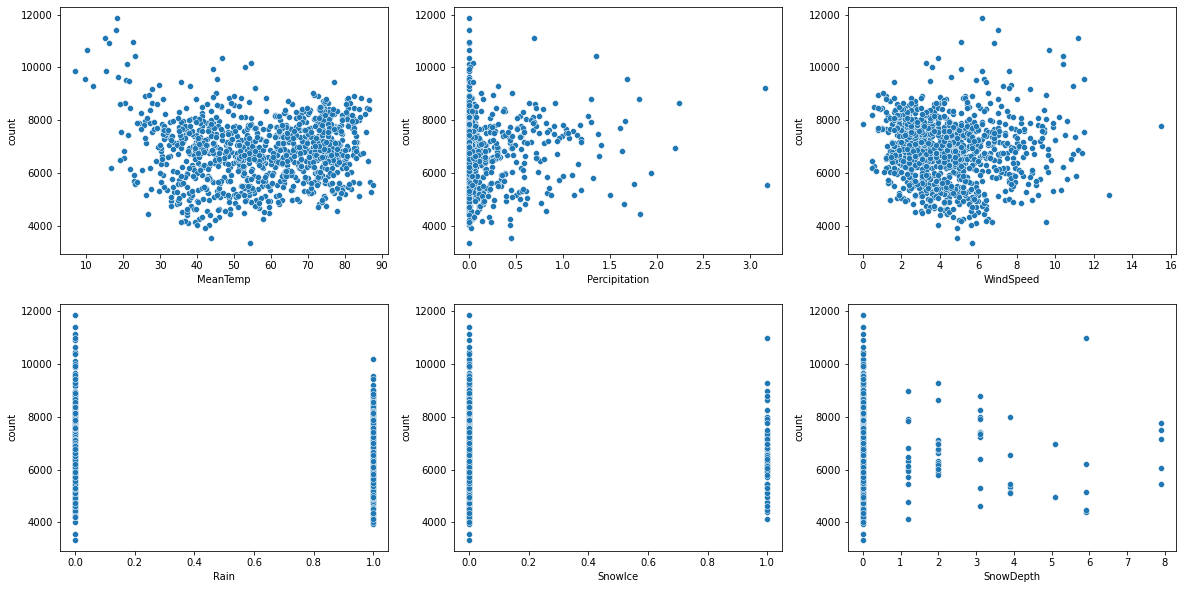

In [29]:
#Before transformation
fig,ax = plt.subplots(2,3,figsize=(20,10))
ax = ax.flatten()
sns.scatterplot(x = lr_df_total['MeanTemp'], y = lr_df_total["count"], ax = ax[0])
sns.scatterplot(x = lr_df_total['Percipitation'], y = lr_df_total["count"], ax = ax[1])
sns.scatterplot(x = lr_df_total['WindSpeed'], y = lr_df_total["count"], ax = ax[2])
sns.scatterplot(x = lr_df_total['Rain'], y = lr_df_total["count"], ax = ax[3])
sns.scatterplot(x = lr_df_total['SnowIce'], y = lr_df_total["count"], ax = ax[4])
sns.scatterplot(x = lr_df_total['SnowDepth'], y = lr_df_total["count"], ax = ax[5])

<AxesSubplot:xlabel='SnowDepth', ylabel='count'>

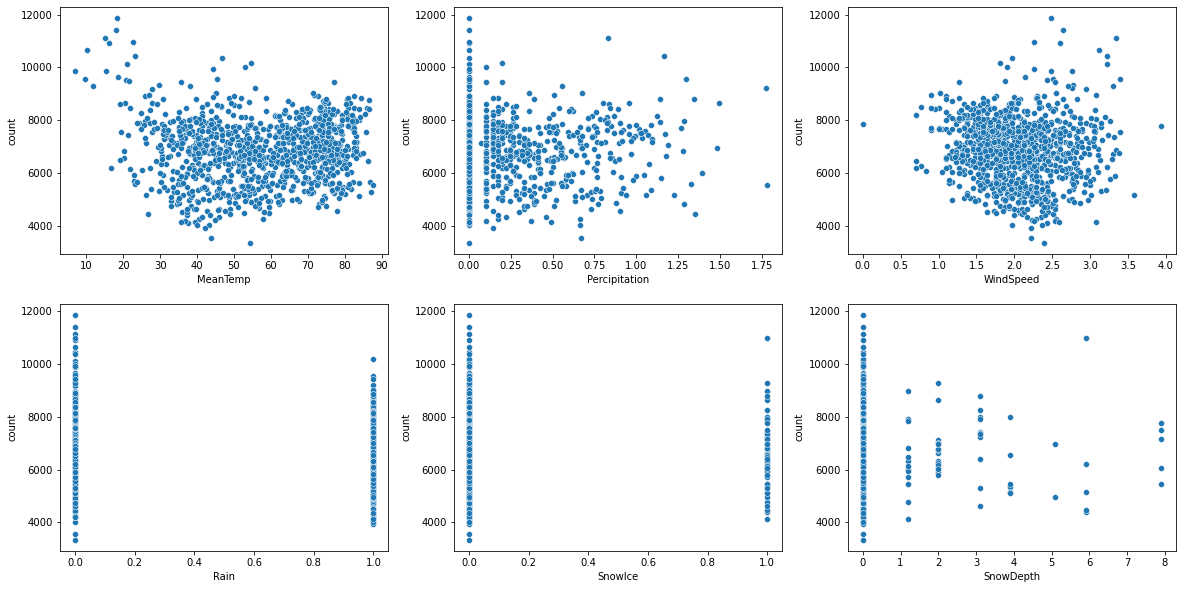

In [30]:
# After transformation
fig,ax = plt.subplots(2,3,figsize=(20,10))
ax = ax.flatten()
sns.scatterplot(x = lr_df_total['MeanTemp'], y = lr_df_total["count"], ax = ax[0])
sns.scatterplot(x = np.sqrt(lr_df_total['Percipitation']), y = lr_df_total["count"], ax = ax[1])
sns.scatterplot(x = np.sqrt(lr_df_total['WindSpeed']), y = lr_df_total["count"], ax = ax[2])
sns.scatterplot(x = lr_df_total['Rain'], y = lr_df_total["count"], ax = ax[3])
sns.scatterplot(x = lr_df_total['SnowIce'], y = lr_df_total["count"], ax = ax[4])
sns.scatterplot(x = lr_df_total['SnowDepth'], y = lr_df_total["count"], ax = ax[5])

In [31]:

lr_df_total = lr_df[["MeanTemp", "Percipitation","WindSpeed","Rain","SnowIce","SnowDepth","count"]]
lr_df_total['Percipitation'] = np.sqrt(lr_df_total['Percipitation'])
lr_df_total['WindSpeed'] = np.sqrt(lr_df_total['WindSpeed'])

lr_df_train =  lr_df[lr_df['Date'] < datetime.datetime(2018,7,1)]
lr_df_train_x = lr_df_train[["MeanTemp", "Percipitation","WindSpeed","Rain","SnowIce","SnowDepth"]]
lr_df_train_x['Percipitation'] = np.sqrt(lr_df_train_x['Percipitation'])
lr_df_train_x['WindSpeed'] = np.sqrt(lr_df_train_x['WindSpeed'])


lr_df_train_y = lr_train_decomposite.resid.fillna(0)
#lr_train_decomposite.observed - lr_train_decomposite.seasonal
lr_df_train_rest = lr_train_decomposite.observed - lr_df_train_y
lr_df_train_y = lr_df_train_y


lr_df_test =  lr_df[lr_df['Date'] >= datetime.datetime(2018,7,1)]
lr_df_test_x = lr_df_test[["MeanTemp", "Percipitation","WindSpeed","Rain","SnowIce", "SnowDepth"]]
lr_df_test_x['Percipitation'] = np.sqrt(lr_df_test_x['Percipitation'])
lr_df_test_x['WindSpeed'] = np.sqrt(lr_df_test_x['WindSpeed'])

lr_df_test_y = lr_test_decomposite.resid.fillna(0)
#lr_test_decomposite.observed - lr_test_decomposite.seasonal
lr_df_test_rest = lr_test_decomposite.observed - lr_df_test_y
lr_df_test_y = lr_df_test_y

In [32]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
lr = LinearRegression()


pf = PolynomialFeatures(2, include_bias = True, interaction_only = False)
lr_df_train_x_transformed = pf.fit_transform(lr_df_train_x)
lr.fit(lr_df_train_x_transformed, lr_df_train_y)
lr_train_pred = lr.predict(lr_df_train_x_transformed)

lr_df_test_x_transformed = pf.transform(lr_df_test_x)
lr_pred = lr.predict(lr_df_test_x_transformed)

"""
lr.fit(lr_df_train_x, lr_df_train_y)
lr_train_pred = lr.predict(lr_df_train_x)
lr_pred = lr.predict(lr_df_test_x)
"""

'\nlr.fit(lr_df_train_x, lr_df_train_y)\nlr_train_pred = lr.predict(lr_df_train_x)\nlr_pred = lr.predict(lr_df_test_x)\n'

[None, None]

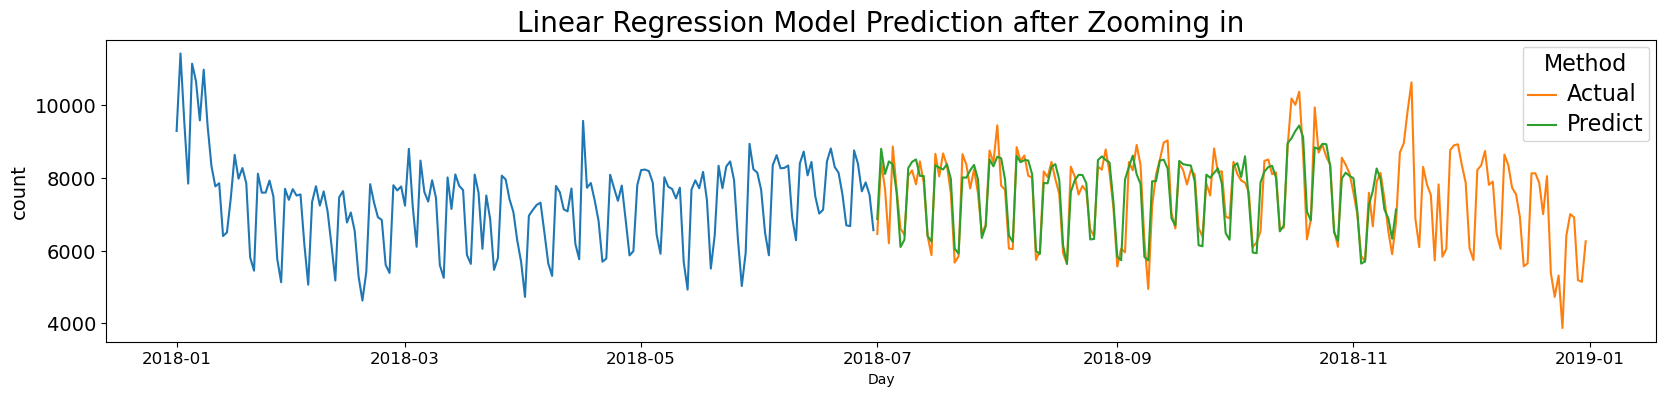

In [33]:
whole_series_train_2018 = whole_series_train[whole_series_train.index >=datetime.datetime(2018,1,1)]
fig,ax = plt.subplots(1,1,figsize=(20,4),dpi =100)
sns.lineplot(whole_series_train_2018.index, whole_series_train_2018, ax = ax)
sns.lineplot(whole_series_test.index, whole_series_test, ax = ax,label = 'Actual')
sns.lineplot(lr_df_test.Date, lr_pred + np.array(lr_df_test_rest) , ax = ax,label = 'Predict')
ax.set_title('Linear Regression Model Prediction after Zooming in', fontsize= 20)
ax.set_ylabel('count', fontsize = 14)
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.legend(title = 'Method',ncol=1,loc=1)
plt.setp(ax.get_legend().get_texts(), fontsize="16")  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize="16")

In [34]:
print(mse(lr_pred + np.array(lr_df_test_rest), lr_test_decomposite.observed))
print(mse(lr_pred  + np.array(lr_df_test_rest), lr_test_decomposite.observed, squared=False ))
print(mape(lr_pred + np.array(lr_df_test_rest), lr_test_decomposite.observed))

235476.17004542233
485.2588691053697
0.04578540760172025


In [35]:
y_pred = lr_train_pred + np.array(lr_df_train_rest)
y_true = lr_train_decomposite.observed

### Linearity Test

In [36]:
def Linearity(y_true, y_pred):
    print('\033[1mCheck for Linearity\033[0m')
    fig,ax=plt.subplots(1,2,figsize=(12,5),dpi=100)
    y_hat = y_pred
    residuals = (y_true - y_hat)
    #plot predicted vs actual
    ax[0].plot(y_hat,y_true,'o')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')
    ax[0].set_title('Predicted vs. Actual')
    ax[0].plot(np.array(ax[0].get_xlim()),np.array(ax[0].get_xlim()),'-',color='red')
    _ = ax[1].scatter(y_hat,residuals)
    ax[1].plot(np.array(ax[1].get_xlim()),np.array([0,0]),'-',color='red')
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Residuals')
    ax[1].set_title('Predicted vs. Residuals:')
    plt.show()

Check for Linearity


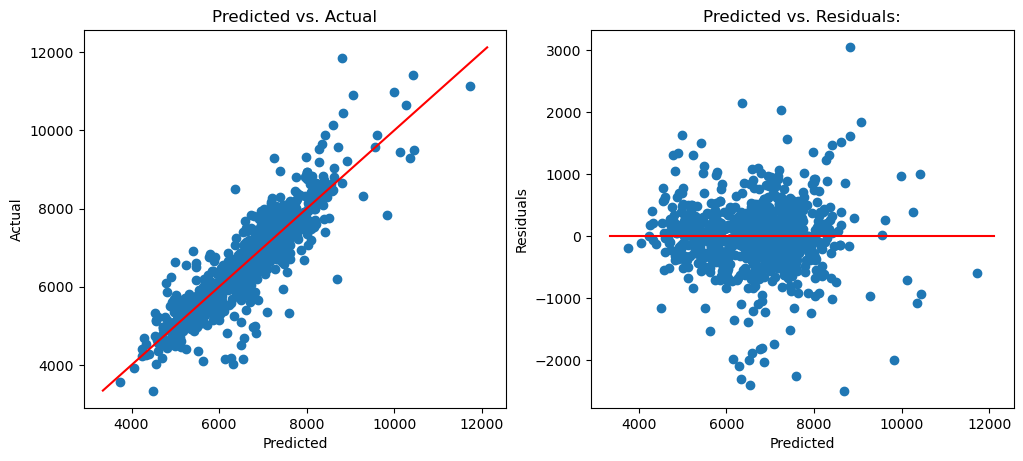

In [37]:
Linearity(y_true, y_pred)

### Normality Test

In [38]:
def Normality(y_true, y_pred):
    print('\033[1mCheck for Normality\033[0m')
    fig,ax=plt.subplots(1,2,figsize=(12,5),dpi=100)
    y_hat = y_pred
    residuals = (y_true-y_hat)
    #plot predicted vs actual   
    _, (__, ___, r) = sp.stats.probplot(residuals, plot=ax[0], fit=True)
    sns.histplot(residuals,kde=True,ax=ax[1])
    ax[1].set_title('Normality of error terms/residuals')
    plt.show()
    mean_residuals = np.mean(residuals)
    print("Mean of Residuals {}".format(mean_residuals))
    print('The p value of the Anderson-Darling test is',normal_ad(residuals)[1])
    if (normal_ad(residuals)[1])<0.05:
        print('The residuals are not normally distributed')
    else:
        print('The residuals are normally distributed')

Check for Normality


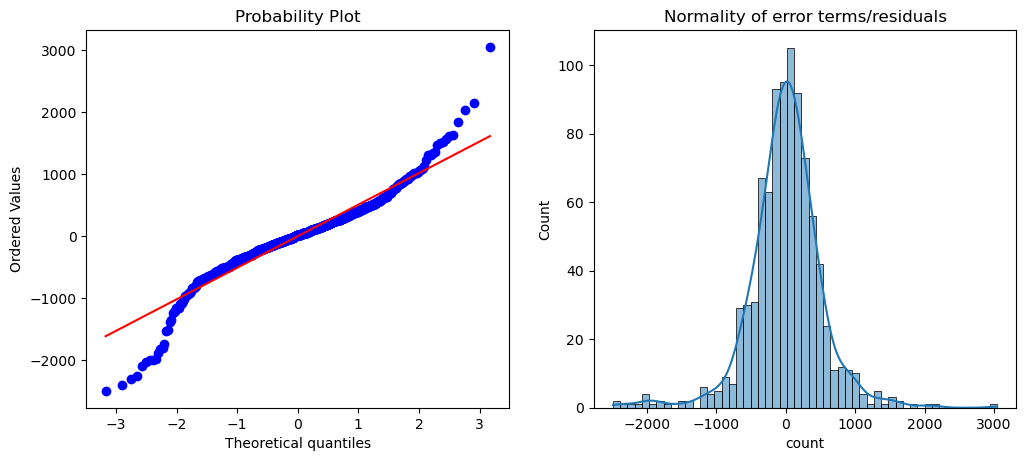

Mean of Residuals 2.255786201107855e-12
The p value of the Anderson-Darling test is 4.305098033457191e-30
The residuals are not normally distributed


In [39]:
Normality(y_true, y_pred)

### Homoscedasticity Test

In [40]:
def Homoscedasticity(y_true, y_pred):
    print('\033[1mCheck for Homoscedasticity\033[0m')
    fig,ax=plt.subplots(1,figsize=(6,5),dpi=100)
    y_hat = y_pred
    residuals = (y_true-y_hat)
    #plot predicted vs residuals
    _ = ax.scatter(y_hat,residuals)
    ax.plot(np.array(ax.get_xlim()),np.array([0,0]),'-',color='red')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Residuals')
    ax.set_title('Predicted vs. Residuals:')
    plt.show()
    name = ['F statistic', 'p-value']
    """
    gq = sms.het_goldfeldquandt(residuals, train)
    lzip(name, gq)
    if gq[1]>0.05:
        print('The result of the Goldfeld Quandt test is',gq)
        print('We can not reject the null hypothesis that the residuals are homoscedastic')
    """    

Check for Homoscedasticity


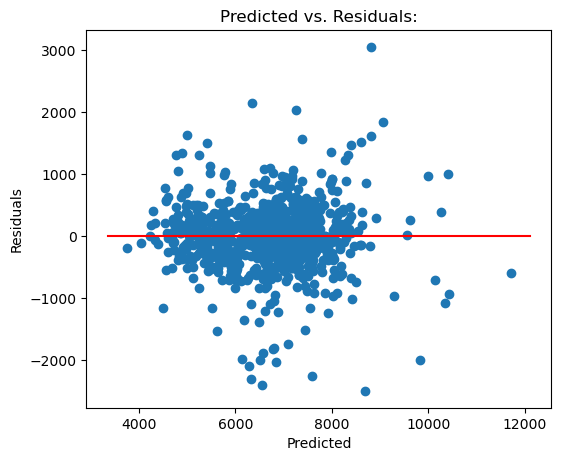

In [41]:
Homoscedasticity(y_true, y_pred)

### Autocorrelation Test

In [42]:
def Autocorrelation(y_true, y_pred):
    print('\033[1mCheck for Autocorrelation\033[1m')
    fig,ax=plt.subplots(1,figsize=(6,5),dpi=100)
    y_hat = y_pred
    residuals = (y_true-y_hat)
    autodf =pd.DataFrame({'x': y_hat,'y':residuals})
    p = sns.lineplot(x = y_hat,y=residuals,marker='o', ax = ax )
    plt.xlabel('y_pred/predicted values')
    plt.ylabel('Residuals')
    plt.xlim(3000,12000)
    p = sns.lineplot(x=[3000,12000],y=[0,0],color='red')
    p = plt.title('Residuals vs fitted values plot for autocorrelation check')
    plt.show()
    durbinWatson = durbin_watson(residuals)
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('There might exist positive autocorrelation')
    elif durbinWatson > 2.5:
        print('There might exist negative autocorrelation')
    else:
        print('There is little to no autocorrelation in residuals')

Check for Autocorrelation


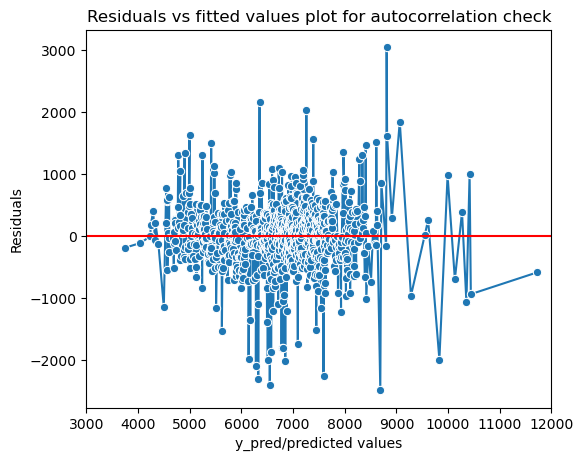

Durbin-Watson: 1.8588335827039326
There is little to no autocorrelation in residuals


In [43]:
Autocorrelation(y_true, y_pred)

In [44]:
def plot_correlation(data, figsize=(10, 10), annot_size=8, fontsize=7, name="corr", save=False):
    corrmat = data.corr()
    hmf, hmax = plt.subplots(figsize=figsize)
    hmax = sns.heatmap(corrmat, vmax=1, vmin=-1, annot=True, square=True, cmap="RdBu", fmt=".2f", annot_kws={"size": annot_size})
    hmax.set_xticklabels(hmax.get_xmajorticklabels(), fontsize=fontsize)
    hmax.set_yticklabels(hmax.get_ymajorticklabels(), fontsize=fontsize)
    plt.title("Correlation of Adjusted Variables", fontsize=18, y=1.05)
    plt.xticks(rotation=45)
    if save == True:
        plt.savefig(name + ".png", bbox_inches="tight")
    plt.show()

In [45]:
def Multicolinearity(y_true, y_pred):
    print('\033[1mCheck for Multicolinearity\033[0m')
    plot_correlation(train)
    new_df = pd.DataFrame()
    if model.params[1:].index.str.contains(':').sum()>0:
        for i in model.params[1:].index.str.split(':'):
            new_df[":".join(i)]=train[i].prod(axis=1)
    else:
        new_df = train[model.params[1:].index]
  
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = model.params.index[1:]
    
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(new_df.values, i) for i in range(len(new_df.columns))]
    print(vif_data)
    print('\n')
    if (vif_data["VIF"]>5).sum()==0:
        print('There does not exist multicolinearity')
    elif (vif_data["VIF"]>10).sum()==0:
        print('There might exist multicolinearity')
    else:
        print('The variable',list(vif_data.query("VIF>10").feature),'are highly correlated')

## Borough Linear Regression Model

In [46]:
raw_weather_data['StationName'].value_counts()

CENTRAL PARK                              1047
JOHN F KENNEDY INTERNATIONAL AIRPORT      1047
LA GUARDIA AIRPORT                        1047
BERGEN POINT                               840
THE BATTERY                                829
KINGS POINT                                826
PORT AUTH DOWNTN MANHATTAN WALL ST HEL     781
Name: StationName, dtype: int64

In [47]:
weather_station_dic = {"MANHATTAN":"CENTRAL PARK", "BRONX":"CENTRAL PARK", "BROOKLYN":"JOHN F KENNEDY INTERNATIONAL AIRPORT",\
"STATEN ISLAND":"CENTRAL PARK"}

In [48]:
total_forcast = []
Borough_names = ["BRONX","STATEN ISLAND","BROOKLYN", "QUEENS","MANHATTAN"]

jfk_data = raw_weather_data[raw_weather_data['StationName'] == "JOHN F KENNEDY INTERNATIONAL AIRPORT"]\
    .drop(['StationName', 'State', 'Borough'], axis = 1).reset_index(drop = True)

lga_data = raw_weather_data[raw_weather_data['StationName'] == "LA GUARDIA AIRPORT"]\
    .drop(['StationName', 'State', 'Borough'], axis = 1).reset_index(drop = True) 

avg_data = jfk_data.copy()
avg_data['MeanTemp'] = (jfk_data['MeanTemp'] + lga_data['MeanTemp'])/2
avg_data['Percipitation'] = (jfk_data['Percipitation'] + lga_data['Percipitation'])/2
avg_data['WindSpeed'] = (jfk_data['WindSpeed'] + lga_data['WindSpeed'])/2
avg_data['Rain'] = (jfk_data['Rain'] + lga_data['Rain'])/2
avg_data['SnowIce'] = (jfk_data['SnowIce'] + lga_data['SnowIce'])/2
avg_data['SnowDepth'] = (jfk_data['SnowDepth'] + lga_data['SnowDepth'])/2

In [49]:
total_counts = []
total_pred = []
for name in Borough_names:   
    
    if name == "QUEENS":
        cp_weather = avg_data.copy()
    else:
        cp_weather = raw_weather_data[raw_weather_data['StationName'] == weather_station_dic[name]]\
        .drop(['StationName', 'State', 'Borough'], axis = 1).reset_index(drop = True)
    
    cp_weather['Date'] = cp_weather['Date']
    right_df = by_borough_df[by_borough_df["Borough"] == name]
    right_df['Day'] =  right_df['Day'].astype(str)
    lr_df = cp_weather.merge(right_df, left_on = 'Date', right_on = 'Day')
    lr_df['Date'] = pd.to_datetime(lr_df['Date'])
    lr_df = lr_df.sort_values(by = ['Date'])


    lr_series_train =  lr_df[lr_df['Date'] < datetime.datetime(2018,7,1)]['count']
    lr_series_train.index = lr_df[lr_df['Date'] < datetime.datetime(2018,7,1)]['Date']
    lr_train_decomposite = seasonal_decompose(lr_series_train,model='addictive')

    lr_series_test =  lr_df[lr_df['Date'] >= datetime.datetime(2018,7,1)]['count']
    lr_series_test.index = lr_df[lr_df['Date'] >= datetime.datetime(2018,7,1)]['Date']
    lr_test_decomposite = seasonal_decompose(lr_series_test,model='addictive')


    lr_df_total = lr_df[["MeanTemp", "Percipitation","WindSpeed","Rain","SnowIce","SnowDepth","count"]]
    lr_df_total['Percipitation'] = np.sqrt(lr_df_total['Percipitation'])
    lr_df_total['WindSpeed'] = np.sqrt(lr_df_total['WindSpeed'])

    lr_df_train =  lr_df[lr_df['Date'] < datetime.datetime(2018,7,1)]
    lr_df_train_x = lr_df_train[["MeanTemp", "Percipitation","WindSpeed","Rain","SnowIce","SnowDepth"]]
    lr_df_train_x['Percipitation'] = np.sqrt(lr_df_train_x['Percipitation'])
    lr_df_train_x['WindSpeed'] = np.sqrt(lr_df_train_x['WindSpeed'])


    lr_df_train_y = lr_train_decomposite.resid.fillna(0)
    #lr_train_decomposite.observed - lr_train_decomposite.seasonal
    lr_df_train_rest = lr_train_decomposite.observed - lr_df_train_y
    lr_df_train_y = lr_df_train_y


    lr_df_test =  lr_df[lr_df['Date'] >= datetime.datetime(2018,7,1)]
    lr_df_test_x = lr_df_test[["MeanTemp", "Percipitation","WindSpeed","Rain","SnowIce", "SnowDepth"]]
    lr_df_test_x['Percipitation'] = np.sqrt(lr_df_test_x['Percipitation'])
    lr_df_test_x['WindSpeed'] = np.sqrt(lr_df_test_x['WindSpeed'])

    lr_df_test_y = lr_test_decomposite.resid.fillna(0)
    #lr_test_decomposite.observed - lr_test_decomposite.seasonal
    lr_df_test_rest = lr_test_decomposite.observed - lr_df_test_y
    lr_df_test_y = lr_df_test_y
    
    
    

    pf = PolynomialFeatures(2, include_bias = True, interaction_only = False)
    lr_df_train_x_transformed = pf.fit_transform(lr_df_train_x)
    lr.fit(lr_df_train_x_transformed, lr_df_train_y)
    lr_train_pred = lr.predict(lr_df_train_x_transformed)

    lr_df_test_x_transformed = pf.transform(lr_df_test_x)
    lr_pred = lr.predict(lr_df_test_x_transformed)
    
    total_counts.append(np.array(lr_test_decomposite.observed))
    total_pred.append(lr_pred + np.array(lr_df_test_rest))
    

[None, None]

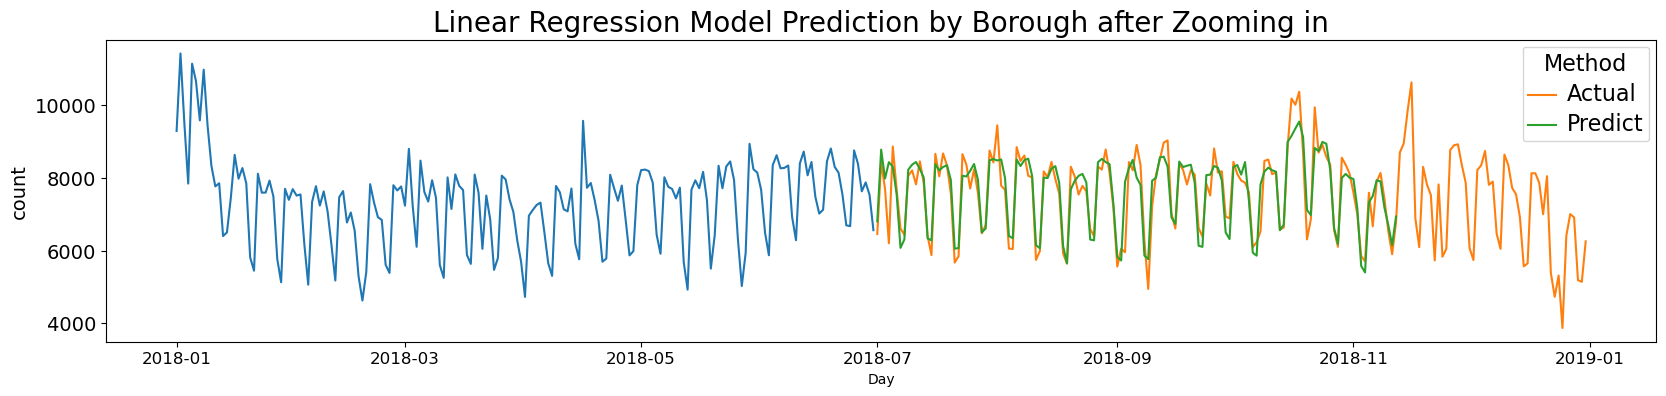

In [50]:
whole_series_train_2018 = whole_series_train[whole_series_train.index >=datetime.datetime(2018,1,1)]
fig,ax = plt.subplots(1,1,figsize=(20,4),dpi= 100)
sns.lineplot(whole_series_train_2018.index, whole_series_train_2018, ax = ax)
sns.lineplot(whole_series_test.index, whole_series_test, ax = ax,label='Actual')
sns.lineplot(lr_df_test.Date, np.sum(total_pred, axis = 0) , ax = ax,label = 'Predict')
ax.set_title('Linear Regression Model Prediction by Borough after Zooming in', fontsize= 20)
ax.set_ylabel('count', fontsize = 14)
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.legend(title = 'Method',ncol=1,loc=1)
plt.setp(ax.get_legend().get_texts(), fontsize="16")  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize="16")

In [51]:
print(mse(np.sum(total_pred, axis = 0), np.sum(total_counts, axis = 0)))
print(mse(np.sum(total_pred, axis = 0), np.sum(total_counts, axis = 0), squared=False ))
print(mape(np.sum(total_pred, axis = 0), np.sum(total_counts, axis = 0)))

218686.52206596232
467.6393076570471
0.04423758056121196


In [52]:
metrics_df_total = metrics_df.copy()

## Metrics for all method

In [53]:
metrics_df_total['LinearRegression'] = [235476.17004542233,485.2588691053697,0.04578540760172025]
metrics_df_total['LinearRegressionBorough'] = [218686.52206596232, 467.6393076570471, 0.04423758056121196]

In [54]:
metrics_df_total.rename(columns = {"Residual":"ARIMAResidual", "Borough":"ARIMABorough"})

,Baseline,ARIMAResidual,ARIMABorough,LinearRegression,LinearRegressionBorough
MSE,1.461135e+06,289184.693119,289223.051681,235476.170045,218686.522066
RMSE,1.208774e+03,537.758954,537.794618,485.258869,467.639308
MAPE,1.455922e-01,0.052847,0.052830,0.045785,0.044238


# Conclusions and Next Steps

## Conclusions


1. We explore, process and visualize 311 calls and weather dataset and obtain several insights.

2. We implement several models with different focuses and verify model assumptions.

3. By incorporating geological information like weather in different boroughs, we achieved the best result.



## Next Steps

1. Some complaint types could be related to weather, we could filter out unrelated 311 calls. 

2. Gather more calls data and weather and try to capture more precise geological patterns in a smaller area (zip code) and to extract more useful insights and intuitions from data.

3. Perform feature selection and transformation techniques based on model assumptions and apply some optimization regularization.

4. Try other machine learning or time series models to capture more information of data ( etc. LSTM, Random Forest, XGBoost).




